In [ ]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# make sure the displays are nice
%matplotlib inline
#figsize(12,8)

In [25]:
from src.arms import *
from BanditBaselines import *
from BanditTools import *
from Experiments import *
from src.stochastic_bandit import *
import matplotlib.pyplot as plt

In [31]:
bandit=BernoulliMAB([.5,.6,.7,.1])
p=Player(nb_arms=4, nb_players=2,alpha=0.1)

(array([  2.,   0.,   0.,  10.,   0.,   0., 986.,   0.,   0.,   2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

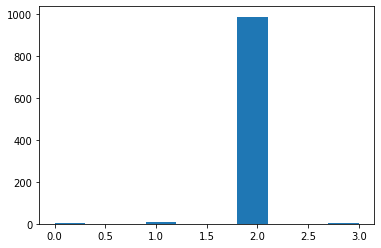

In [33]:
T=1000
s,r=OneBanditOneLearnerOneRun(bandit, p,T)
plt.hist(s)

In [64]:
class RandTopM:
    def __init__(self, nb_arms, nb_players,alpha=0.1):
        self.alpha=alpha
        self.nb_arms= nb_arms
        self.nb_players=nb_players
        self.clear()

    def clear(self):
        self.nb_draws = np.zeros(self.nb_arms)
        self.cum_rewards = np.zeros(self.nb_arms)
        self.best_arms=np.zeros(self.nb_players)
        self.ucbs=np.zeros(self.nb_arms)
        self.my_arm=None
        self.t = 0
        self.has_collided=False

    def chooseArmToPlay(self):
        self.t=self.t+1
        if min(self.nb_draws)==0:
             return randmax(-self.nb_draws)
        else:
            ucbs_new = self.cum_rewards/self.nb_draws + np.sqrt(self.alpha*log(self.t)/self.nb_draws) 
    
        best_arms = np.argsort(ucbs_new)[::-1][:self.nb_players]  # M best arms

        if self.my_arm in ucbs_new:  # if my arm is still a best arm
            return self.my_arm

        elif self.has_collided:
            return np.random.choice(best_arms)

        else:  # no collision            
            new_arms_to_choose = np.where((self.ucbs <= self.ucbs[self.my_arm]) & (ucbs_new >= ucbs_new[best_arms[-1]]))[0]
            self.ucbs = ucbs_new
            return np.random.choice(new_arms_to_choose)

    def receiveReward(self,arm,reward, collision):
        self.cum_rewards[arm] = self.cum_rewards[arm]+reward
        self.nb_draws[arm] = self.nb_draws[arm] +1
        self.has_collided=collision
        self.my_arm=arm

    def name(self):
        return "RandTopM"

In [65]:
class P:
    def __init__(self, nb_arms, nb_players,strategy):
        self.nb_arms= nb_arms
        self.nb_players=nb_players
        self.strategy=strategy(self.nb_arms,self.nb_players)
        self.clear()
    def clear(self):
        self.strategy.clear()
    def chooseArmToPlay(self):
        return self.strategy.chooseArmToPlay()
    def receiveReward(self,arm,reward,collision):
        self.strategy.receiveReward(arm,reward, collision)

In [36]:
pp=P(3, 3,RandTopM)

In [66]:
class PlaySession:
    def __init__(self, players,bandit):
        self.players=players
        self.bandit=bandit
        self.nb_arms=bandit.nb_arms
        self.nb_players= len(players)
        self.clear()

    def clear(self):
        self.c=np.zeros(self.nb_arms,dtype="bool")
        
    def run(self,T):
        for t in range(T):
            arm_chosen=np.array([self.players[i].chooseArmToPlay() for i in range(self.nb_players)])# each player choose an arm
            self.c=[np.count_nonzero(arm_chosen==k)>1 for k in range(self.nb_arms)]
            # distribute rewards to each players
            for i in range (self.nb_players):
                self.players[i].receiveReward(arm_chosen[i],bandit.generate_reward(arm_chosen[i]),self.c[i])

In [67]:
players=[P(nb_arms=3, nb_players=2,strategy=RandTopM) for i in range(2)]
bandit=BernoulliMAB([.5,.6,.7])
play_session=PlaySession(players,bandit)

In [68]:
play_session.run(100)